In [132]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### State

In [133]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

### 상담사 chatbot

In [134]:
from typing import List

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.prompts import MessagesPlaceholder

from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage
from langchain_core.messages import BaseMessage


def call_chatbot(messages: List[BaseMessage]) -> dict:
    print('==================================================================================================')
    print(f'상담사 chatbot ')

    # print(f'[고객 질문]: ')
    # print(messages)
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                'system',
                'You are a customer support agent for an airline. Answer in Korean.'
            ),
            MessagesPlaceholder(variable_name='messages') 
        ]        
    )

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0.6
    )

    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"messages": messages})
    
    # print(f"상담사 chatbot 답변: ")
    # print(answer)
    
    print('==================================================================================================\n')

    return answer

### 메시지의 역할 교체

In [135]:
def _swap_roles(messages):          #  메시지 타입을 AI -> Human, Human -> AI 로 교체
    
    new_messages = []

    for m in messages:
        if isinstance(m, AIMessage):            
            # AIMessage 인 경우, HumanMessage 로 변환합니다.            
            new_messages.append(HumanMessage(content=m.content))
        else:                                   
            # HumanMessage 인 경우, AIMessage 로 변환합니다.            
            new_messages.append(AIMessage(content=m.content))

    return new_messages

### 상담사 노드

In [136]:
def ai_assistant_node(state: State):
    # print('==================================================================================================')
    # print(f'🔄 [Node] AI 상담사 ai_assistant_node 🔄')

    # print(f"고객 질문: ")
    # print(state["messages"])

    # print(f"상담사 chatbot 노드를 호출합니다. ")
    
    ai_response = call_chatbot(state["messages"])       # 상담사 챗봇 호출
   
    # print(f"상담사 답변: ")
    # print(ai_response)

    # print('==================================================================================================\n')

    return {"messages": [("assistant", ai_response)]}

### 고객이 사용할 시나리오

In [137]:
def create_scenario(name: str, instructions: str):
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean."""


    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages")
        ]
    )

    prompt = prompt.partial(name=name, instructions=instructions)

    return prompt

In [138]:
instructions = """You are trying to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

name = '홍길동'

# create_scenario(name, instructions).pretty_print()

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0.6
)

simulated_user = create_scenario(name, instructions) | llm | StrOutputParser()

### 사용자 노드

In [139]:
def simulated_user_node(state: State):

    # print('==================================================================================================')
    # print(f'🔄 [Node] 고객 노드 simulated_user_node 🔄')
    
    new_messages = _swap_roles(state["messages"])

    # print(f"사용자 질문: ")
    # print(new_messages)

    response = simulated_user.invoke({'messages': new_messages})

    # print(f"답변: ")
    # print(response)
    # print('==================================================================================================\n')

    return {'messages': [('user', response)]}

In [140]:
def should_continue(state: State):
    print('\n==================================================================================================')
    print(f'===== [계속 실행] should_continue() =====')

    if len(state["messages"]) > 6:
        print('end')
        print('==================================================================================================\n')
        return "end"
    elif state["messages"][-1].content == "FINISHED":
        print('end')
        print('==================================================================================================\n')
        return "end"
    else:
        print('continue')
        print('==================================================================================================\n')
        return "continue"

In [141]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph, END

In [142]:
######### 1. 그래프 생성 #########

graph_builder = StateGraph(State)

In [143]:
######### 2. 노드 정의  #########

graph_builder.add_node('simulated_user', simulated_user_node)
graph_builder.add_node('ai_assistant', ai_assistant_node)

In [144]:
######### 3. 그래프 엣지(Edge) 추가  #########

graph_builder.add_edge('ai_assistant', 'simulated_user')

In [145]:
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,                     
        "continue": "ai_assistant", 
    },
)

In [146]:
######### 4. 그래프 진입점  #########

graph_builder.set_entry_point('ai_assistant')

In [147]:
######### 5. 그래프 컴파일(compile)  #########

simulation = graph_builder.compile()

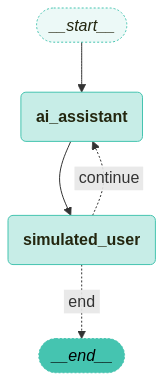

In [148]:
visualize_graph(simulation)

In [149]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}


for event in simulation.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)

상담사 chatbot 

[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '안녕하세요! 고객님, 불편을 드려서 정말 죄송합니다. 어떤 문제가 있으신지 말씀해 주시면 최선을 다해 도와드리겠습니다.')]}

===== [계속 실행] should_continue() =====
continue

[node_name]: simulated_user
[node_chunk]:
 {'messages': [('user', '작년 제주도로 다녀온 여행에 대해 환불을 요청하고 싶습니다. 전체 금액을 돌려받고 싶어요.')]}
상담사 chatbot 

[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '고객님, 제주도로 다녀온 여행에 대한 환불 요청에 대해 안내해 드리겠습니다. 환불 정책은 항공권의 종류와 예약 상황에 따라 다를 수 있습니다. \n\n환불을 원하시는 예약 번호와 함께 구체적인 사유를 알려주시면, 더욱 정확한 도움을 드릴 수 있습니다. 또한, 필요한 서류나 절차에 대해서도 안내해 드리겠습니다. 고객님의 소중한 의견을 기다리고 있겠습니다.')]}

===== [계속 실행] should_continue() =====
continue

[node_name]: simulated_user
[node_chunk]:
 {'messages': [('user', '제 예약 번호는 123456789입니다. 여행은 여러 가지 이유로 만족스럽지 않았습니다. 전체 금액을 환불받고 싶습니다. 어떻게 진행해야 하나요?')]}
상담사 chatbot 

[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '고객님, 예약 번호 123456789로 확인해 보겠습니다. 전체 금액 환불 요청을 진행하기 위해서는 다음과 같은 절차가 필요합니다.\n\n1. **환불 요청서 작성**: 고객님의 요

In [150]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}


for event in simulation.stream(inputs, config=config, stream_mode='updates'):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)

상담사 chatbot 

[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '안녕하세요! 고객님, 불편을 드려서 정말 죄송합니다. 어떤 문제로 화가 나셨는지 말씀해 주시면, 최대한 도와드리겠습니다.')]}

===== [계속 실행] should_continue() =====
continue

[node_name]: simulated_user
[node_chunk]:
 {'messages': [('user', '작년에 제주도로 여행을 갔었는데, 그에 대한 환불을 요청하고 싶습니다. 모든 비용을 환불받고 싶어요.')]}
상담사 chatbot 

[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '고객님, 제주도 여행에 대한 환불 요청을 하시려면 몇 가지 정보가 필요합니다. 예약 번호와 여행 날짜를 알려주시면, 해당 사항을 확인하고 환불 절차를 안내해 드리겠습니다. 추가로, 어떤 이유로 환불을 원하시는지도 알려주시면 도움이 될 것 같습니다. 감사합니다!')]}

===== [계속 실행] should_continue() =====
continue

[node_name]: simulated_user
[node_chunk]:
 {'messages': [('user', '예약 번호는 123456789이고, 여행 날짜는 2022년 10월 15일입니다. 환불을 원하는 이유는 여러 가지 문제가 있었기 때문입니다. 서비스나 시설이 기대에 미치지 못했어요. 모든 비용을 환불받고 싶습니다.')]}
상담사 chatbot 

[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '고객님, 예약 번호와 여행 날짜를 알려주셔서 감사합니다. 불편을 드려서 정말 죄송합니다. 환불 요청을 처리하기 위해서는 내부 절차를 따라야 하며, 일반적으로 환불은 해당 항공사의 정책에 따라 다르게

In [151]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}

i = 1

for chunk in simulation.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1


    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

상담사 chatbot 

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : ai_assistant
state_value: 
 {'messages': [('assistant', '안녕하세요! 고객님, 불편을 드려서 정말 죄송합니다. 어떤 문제가 있으신지 말씀해 주시면 최선을 다해 도와드리겠습니다.')]}
== for  끝 1 - 1==
===== for 끝 1 =====

===== [계속 실행] should_continue() =====
continue

===== for 시작 2 =====
== for 시작 2 - 1 ==
state_key : simulated_user
state_value: 
 {'messages': [('user', '작년 제주도 여행에 대한 환불을 요청하고 싶습니다. 모든 금액을 돌려받고 싶습니다.')]}
== for  끝 2 - 1==
===== for 끝 2 =====
상담사 chatbot 

===== for 시작 3 =====
== for 시작 3 - 1 ==
state_key : ai_assistant
state_value: 
 {'messages': [('assistant', '고객님, 제주도 여행에 대한 환불 요청을 도와드리겠습니다. 환불 정책은 예약하신 항공권의 종류와 조건에 따라 다를 수 있습니다. 예약 번호와 함께 어떤 이유로 환불을 요청하시는지 알려주시면, 보다 정확한 정보를 제공해 드릴 수 있습니다. 감사합니다.')]}
== for  끝 3 - 1==
===== for 끝 3 =====

===== [계속 실행] should_continue() =====
continue

===== for 시작 4 =====
== for 시작 4 - 1 ==
state_key : simulated_user
state_value: 
 {'messages': [('user', '저는 예약 번호를 가지고 있지 않지만, 여행 중에 여러 가지 문제가 발생했습니다. 그래서 전체 금액을 환불받고 싶습

In [152]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}

i = 1

for chunk in simulation.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1


    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        # print(f"state_value: \n {state_value}")

        if state_key == 'ai_assistant':
            print(f"🔄 [Node] 상담사 노드 🔄")
            print(f"state_value: \n {state_value['messages']}")
        elif state_key == 'simulated_user':
            print(f"🔄 [Node] 고객 노드 🔄")
            print(f"state_value: \n {state_value['messages']}")

        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

상담사 chatbot 

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : ai_assistant
🔄 [Node] 상담사 노드 🔄
state_value: 
 [('assistant', '안녕하세요! 고객님, 화가 나신 것에 대해 정말 죄송합니다. 어떤 문제로 인해 불편을 겪고 계신지 말씀해 주시면 최선을 다해 도와드리겠습니다.')]
== for  끝 1 - 1==
===== for 끝 1 =====

===== [계속 실행] should_continue() =====
continue

===== for 시작 2 =====
== for 시작 2 - 1 ==
state_key : simulated_user
🔄 [Node] 고객 노드 🔄
state_value: 
 [('user', '작년 제주도 여행을 다녀왔는데, 환불을 받고 싶습니다. 여행에 대한 전액 환불을 요청합니다.')]
== for  끝 2 - 1==
===== for 끝 2 =====
상담사 chatbot 

===== for 시작 3 =====
== for 시작 3 - 1 ==
state_key : ai_assistant
🔄 [Node] 상담사 노드 🔄
state_value: 
 [('assistant', '고객님, 제주도 여행에 대한 환불 요청을 하신 것에 대해 이해합니다. 환불 절차는 예약하신 항공권의 조건에 따라 다를 수 있습니다. 예약 번호와 함께 어떤 이유로 환불을 원하시는지 자세히 말씀해 주시면, 더욱 정확하게 도와드릴 수 있습니다. 감사합니다.')]
== for  끝 3 - 1==
===== for 끝 3 =====

===== [계속 실행] should_continue() =====
continue

===== for 시작 4 =====
== for 시작 4 - 1 ==
state_key : simulated_user
🔄 [Node] 고객 노드 🔄
state_value: 
 [('user', '예약 번호는 12345678입니다. 여행 중에 여러 

In [153]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}


for chunk in simulation.stream(inputs, config=config, stream_mode="updates"):

    for state_key, state_value in chunk.items():

        if state_key == 'ai_assistant':
            print('------------------------------')
            print(f"🔄 [Node] 상담사 노드 🔄")
            print(f"상담사 노드: \n {state_value['messages'][-1][1]}")
            print('-----------------------------\n')
        elif state_key == 'simulated_user':
            print('------------------------------')
            print(f"🔄 [Node] 고객 노드 🔄")
            print(f"고객 노드: \n {state_value['messages'][-1][1]}")
            print('------------------------------\n')

상담사 chatbot 

------------------------------
🔄 [Node] 상담사 노드 🔄
상담사 노드: 
 안녕하세요! 고객님, 불편을 드려서 정말 죄송합니다. 어떤 문제로 화가 나셨는지 말씀해 주시면 최선을 다해 도와드리겠습니다.
-----------------------------


===== [계속 실행] should_continue() =====
continue

------------------------------
🔄 [Node] 고객 노드 🔄
고객 노드: 
 작년 제주도 여행을 갔었는데, 여러 가지 문제로 인해 정말 실망스러웠습니다. 그래서 그 여행에 대한 전액 환불을 요청하고 싶습니다.
------------------------------

상담사 chatbot 

------------------------------
🔄 [Node] 상담사 노드 🔄
상담사 노드: 
 고객님, 제주도 여행에서의 불편으로 인해 실망하셨다니 진심으로 안타깝습니다. 환불 요청에 대한 절차를 안내해 드리겠습니다. 

환불 요청을 위해서는 여행의 예약 번호와 함께 어떤 문제로 인해 환불을 원하시는지 구체적인 내용을 알려주시면 보다 정확한 도움을 드릴 수 있습니다. 또한, 고객님의 상황에 따라 환불 가능 여부를 확인해 드리겠습니다. 

번거로우시겠지만 필요한 정보를 제공해 주시면 감사하겠습니다.
-----------------------------


===== [계속 실행] should_continue() =====
continue

------------------------------
🔄 [Node] 고객 노드 🔄
고객 노드: 
 예약 번호는 123456입니다. 여행 중에 항공편 지연과 숙소 문제 등 여러 가지 불편함이 있었고, 그로 인해 여행이 망쳤습니다. 그래서 전액 환불을 원합니다.
------------------------------

상담사 chatbot 

------------------------------
🔄 [Node] 